In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import os
os.chdir('..')

In [3]:
import warnings
warnings.filterwarnings('ignore', '', UserWarning)

In [4]:
import torch
import torchvision

torch.manual_seed(1)
torch.cuda.manual_seed(1)
device = 'gpu'

## Without normalization

In [10]:
latent_size = 8
batch_size = 32
hidden_size = 400
alpha = 0.5
learning_rate = 0.001
epochs = 11
dataset = 'mnist'
device = 'cuda'
log_interval = 2000
report_interval = 100
reload_model = False
sample_size = 64
normalize = False

In [11]:
from src.utils import get_datasets
train_loader, test_loader, (width, height, channels) = get_datasets(
    dataset, batch_size, device, root='data')

Loading mnist dataset...
Done!



In [14]:
from src.models.vsc import VariationalSparseCoding
vsc = VariationalSparseCoding(dataset, width, height, channels, hidden_size,
                              latent_size, learning_rate, alpha, device, 
                              log_interval, normalize)

In [16]:
%%time
vsc.run_training(train_loader, test_loader, epochs, report_interval, 
                 sample_size, reload_model)

Training VSC model...
Train Epoch: 1 [0/60000 (0%)]	Loss: 125.934814
====> Epoch: 1 Average loss: 129.1704
====> Test set loss: 126.2956 - VLB-VSC : 4035.0020
Train Epoch: 2 [0/60000 (0%)]	Loss: 131.434311
====> Epoch: 2 Average loss: 126.0754
====> Test set loss: 124.5015 - VLB-VSC : 3977.6844
Train Epoch: 3 [0/60000 (0%)]	Loss: 139.735153
====> Epoch: 3 Average loss: 124.2513
====> Test set loss: 122.8291 - VLB-VSC : 3924.2511
Train Epoch: 4 [0/60000 (0%)]	Loss: 111.191299
====> Epoch: 4 Average loss: 122.8721
====> Test set loss: 121.7048 - VLB-VSC : 3888.3318
Train Epoch: 5 [0/60000 (0%)]	Loss: 132.658066
====> Epoch: 5 Average loss: 121.7779
====> Test set loss: 120.6124 - VLB-VSC : 3853.4323
Train Epoch: 6 [0/60000 (0%)]	Loss: 117.484619
====> Epoch: 6 Average loss: 120.9462
====> Test set loss: 120.2050 - VLB-VSC : 3840.4168
Train Epoch: 7 [0/60000 (0%)]	Loss: 115.609360
====> Epoch: 7 Average loss: 120.3329
====> Test set loss: 120.0004 - VLB-VSC : 3833.8783
Train Epoch: 8 [0/6

## With normalization

In [17]:
normalize = True

In [18]:
from src.models.vsc import VariationalSparseCoding
vsc_norm = VariationalSparseCoding(dataset, width, height, channels, hidden_size,
                              latent_size, learning_rate, alpha, device, 
                              log_interval, normalize)

In [19]:
%%time
vsc_norm.run_training(train_loader, test_loader, epochs, report_interval, 
                 sample_size, reload_model)

Calculating norm mean of training set
count    60000.000000
mean         9.214689
std          1.702814
min          3.569828
25%          8.022050
50%          9.200295
75%         10.363036
max         17.179047
dtype: float64
Done!

Training VSC model...
Train Epoch: 1 [0/60000 (0%)]	Loss: 556.642212
====> Epoch: 1 Average loss: 54.9443
====> Test set loss: 49.2538 - VLB-VSC : 1573.6034
Train Epoch: 2 [0/60000 (0%)]	Loss: 51.980347
====> Epoch: 2 Average loss: 48.6417
====> Test set loss: 48.8970 - VLB-VSC : 1562.2032
Train Epoch: 3 [0/60000 (0%)]	Loss: 48.209095
====> Epoch: 3 Average loss: 48.3375
====> Test set loss: 48.6334 - VLB-VSC : 1553.7839
Train Epoch: 4 [0/60000 (0%)]	Loss: 46.077869
====> Epoch: 4 Average loss: 48.1734
====> Test set loss: 48.5682 - VLB-VSC : 1551.7001
Train Epoch: 5 [0/60000 (0%)]	Loss: 53.813324
====> Epoch: 5 Average loss: 48.0619
====> Test set loss: 48.4381 - VLB-VSC : 1547.5444
Train Epoch: 6 [0/60000 (0%)]	Loss: 49.178715
====> Epoch: 6 Average lo

In [20]:
mnist_images, _ = iter(test_loader).next()

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_image(img, ax):
    ax.imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
    
def plot_encoding(image, vsc, latent_sz, alpha, negative=True, width=1/7):
    flattened_image = vsc.normalize(image).to(vsc.device)
    decoded, mu, logvar, logspike = vsc.model.forward(flattened_image)
    z = vsc.model.reparameterize(mu, logvar, logspike)
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(21,7))
    
    img = torchvision.utils.make_grid(image).detach().numpy()
    if negative: img = 1 - img
    plot_image(img, ax0)
    ax0.set_title('Input Image', fontsize=20)
    
    ax1.bar(np.arange(z.shape[1]), height=z.cpu().detach().numpy()[0],
            width=width, align='center')
    ax1.scatter(np.arange(z.shape[1]), z.cpu().detach().numpy()[0],
            color='blue')
    ax1.set_title(r"Latent Dimension %d - $\alpha$ = %.2f " % \
                  (z.shape[1], alpha), fontsize=20)
    
    img = vsc.denormalize(vsc.model.decode(z))
    img = torchvision.utils.make_grid(
            img.view(1,vsc.channels,vsc.height,vsc.width)) \
            .cpu().detach().numpy()
    if negative: img = 1 - img
    plot_image(img, ax2)
    ax2.set_title('Decoded Image', fontsize=20)
    plt.subplots_adjust(hspace=0.5)

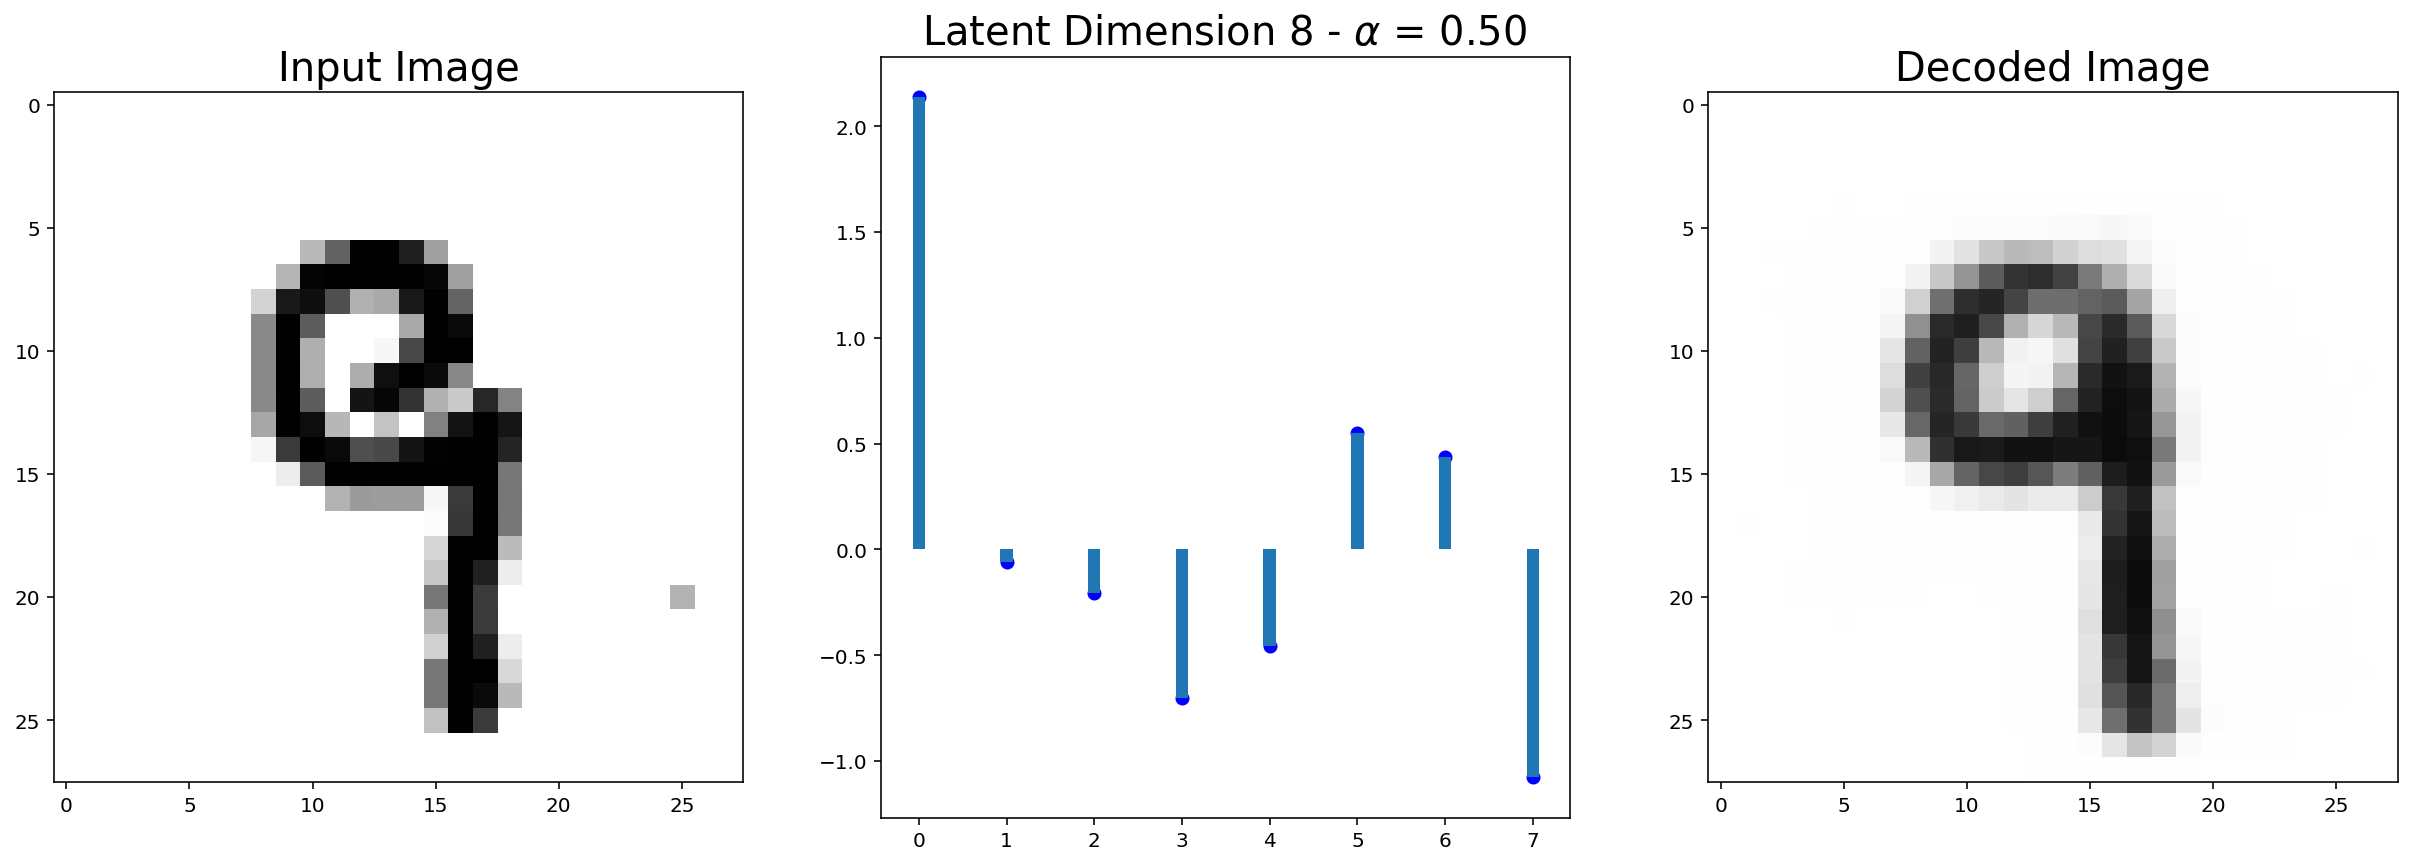

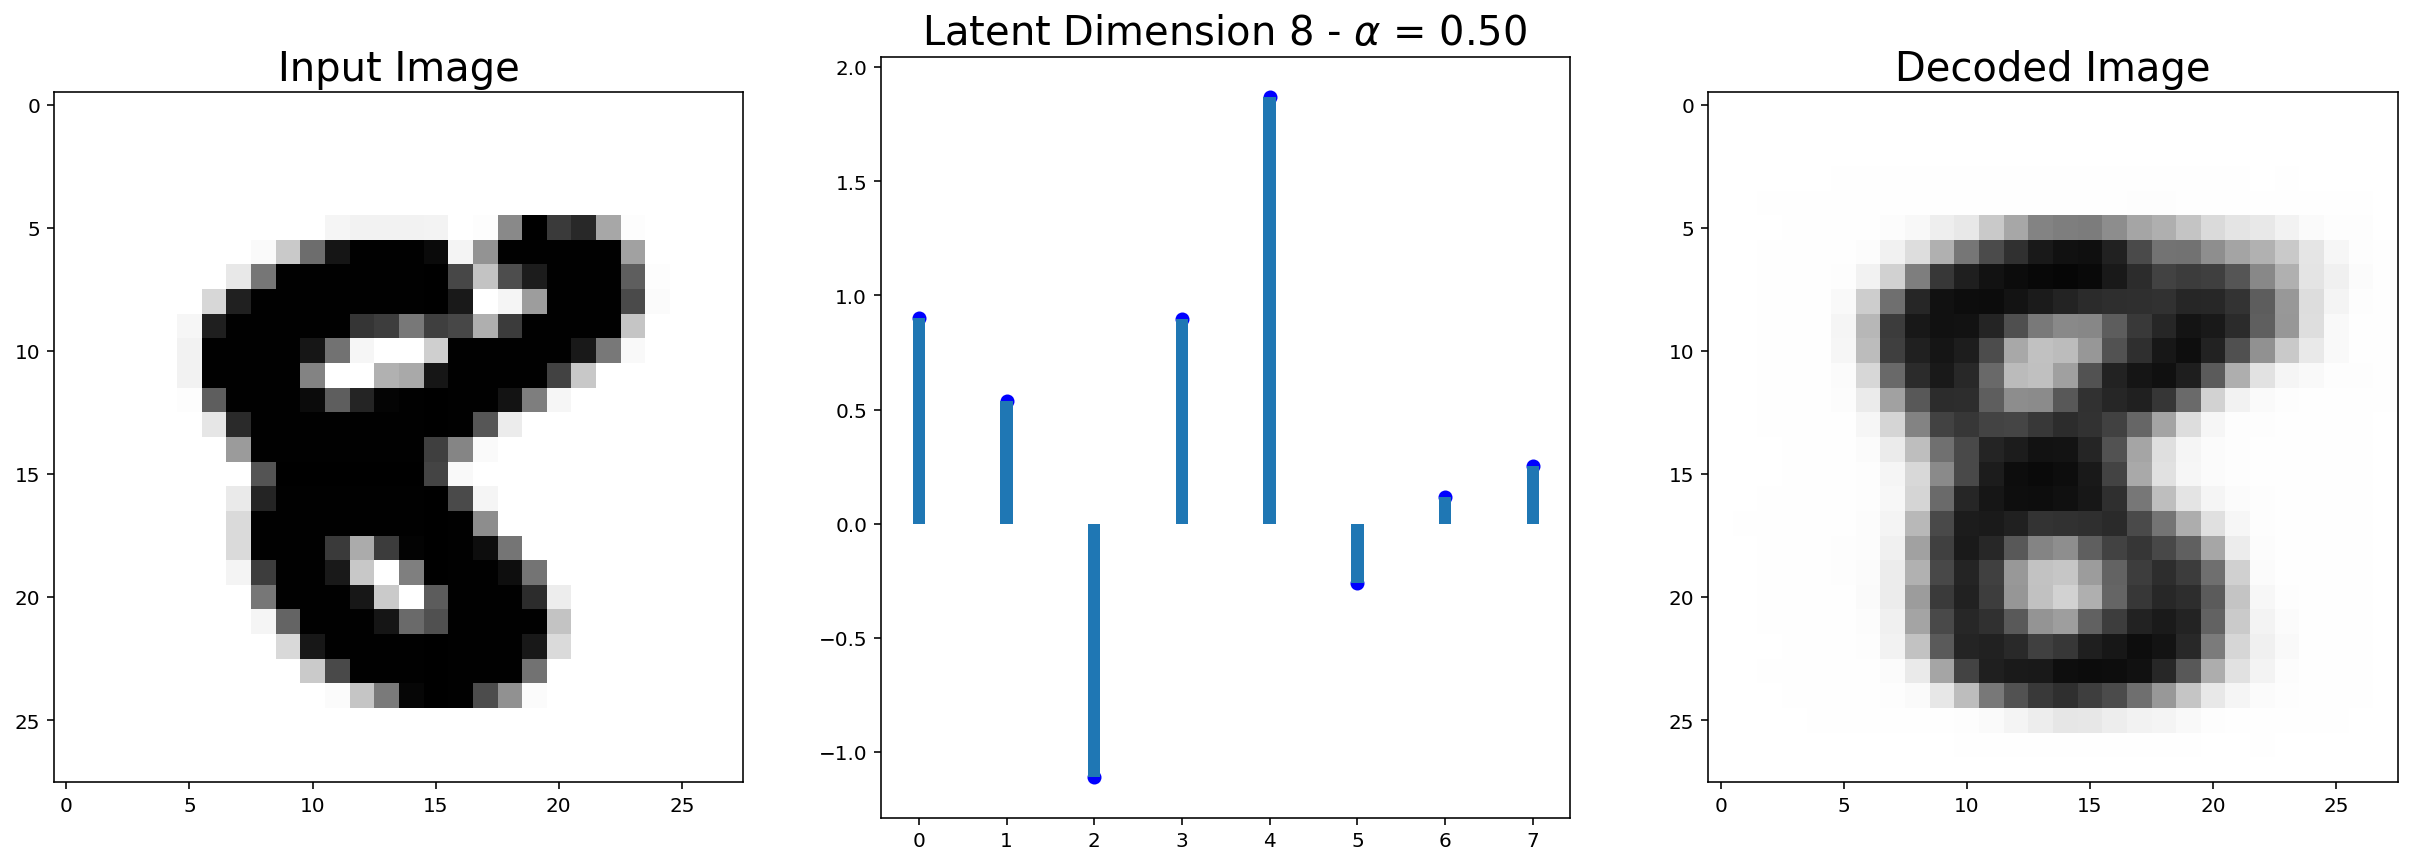

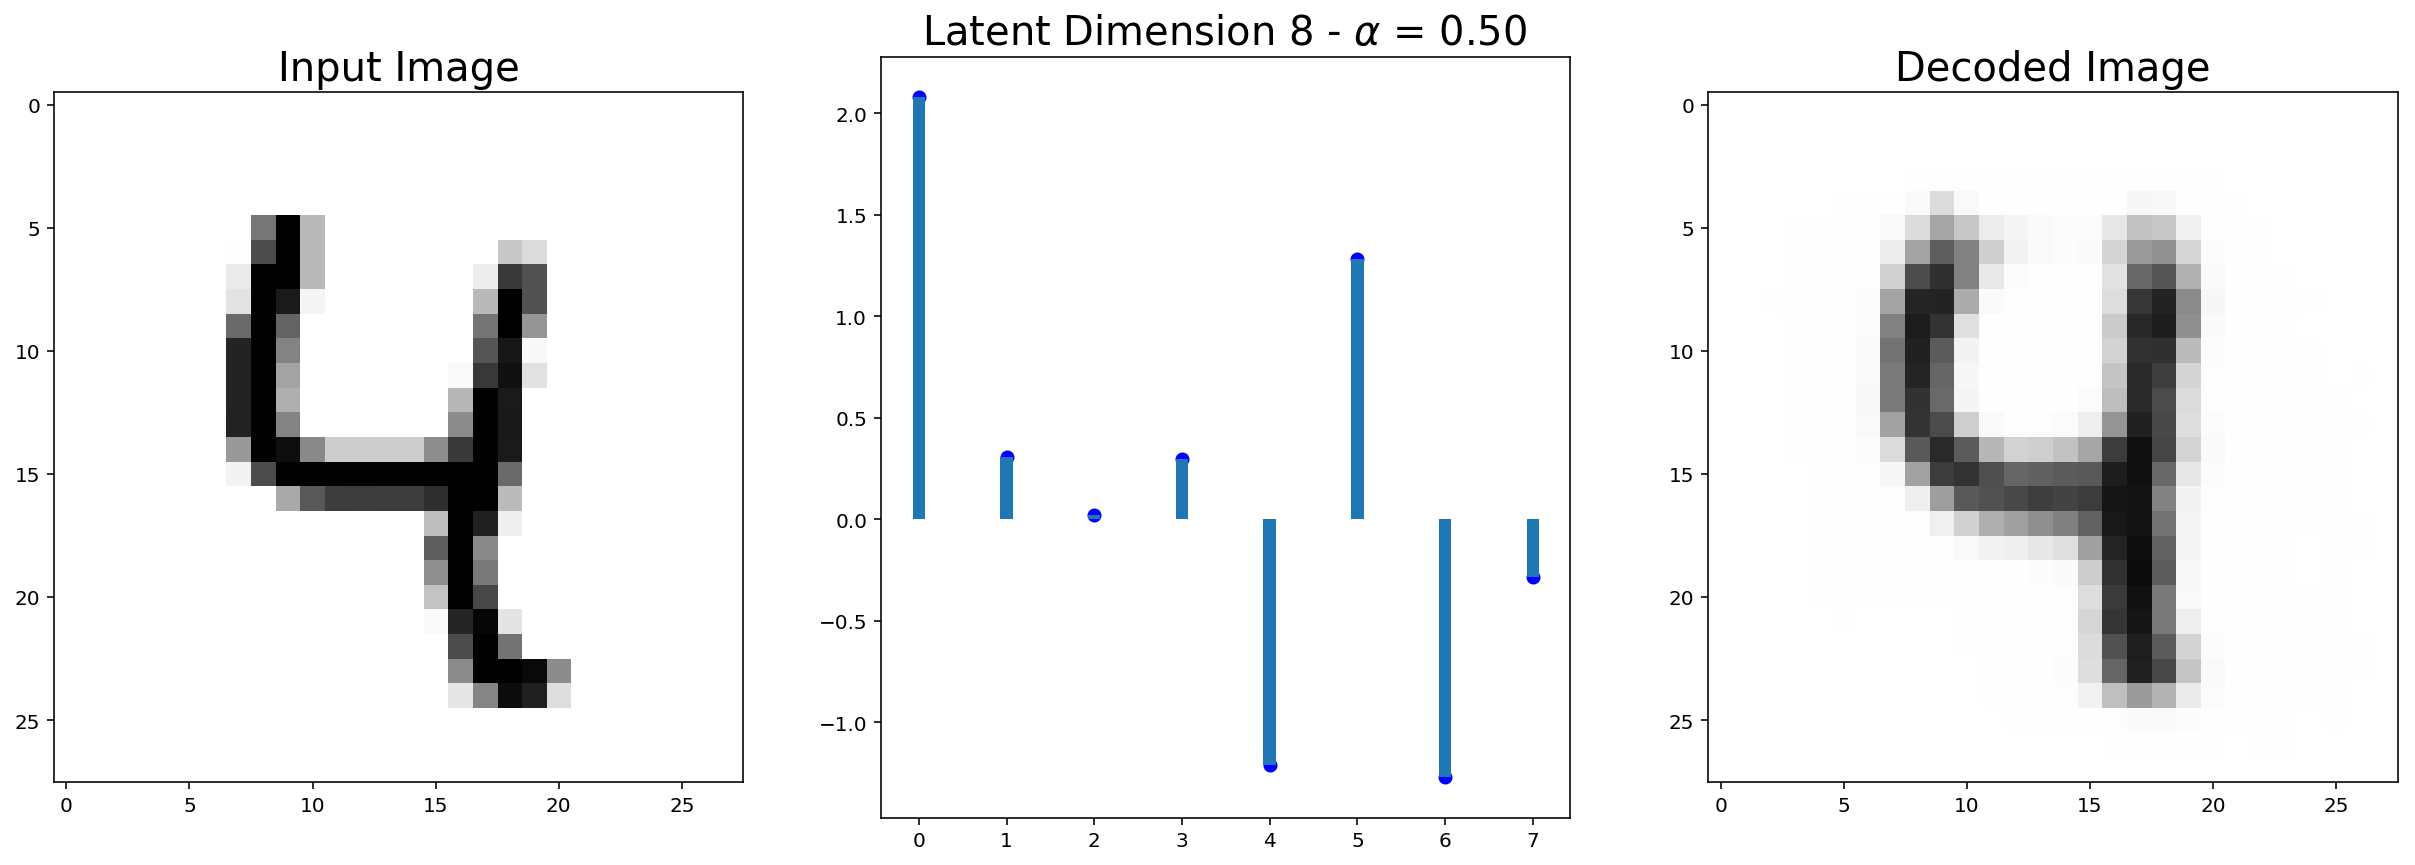

In [22]:
plot_encoding(mnist_images[15], vsc, latent_size, alpha)
plot_encoding(mnist_images[20], vsc, latent_size, alpha)
plot_encoding(mnist_images[25], vsc, latent_size, alpha)

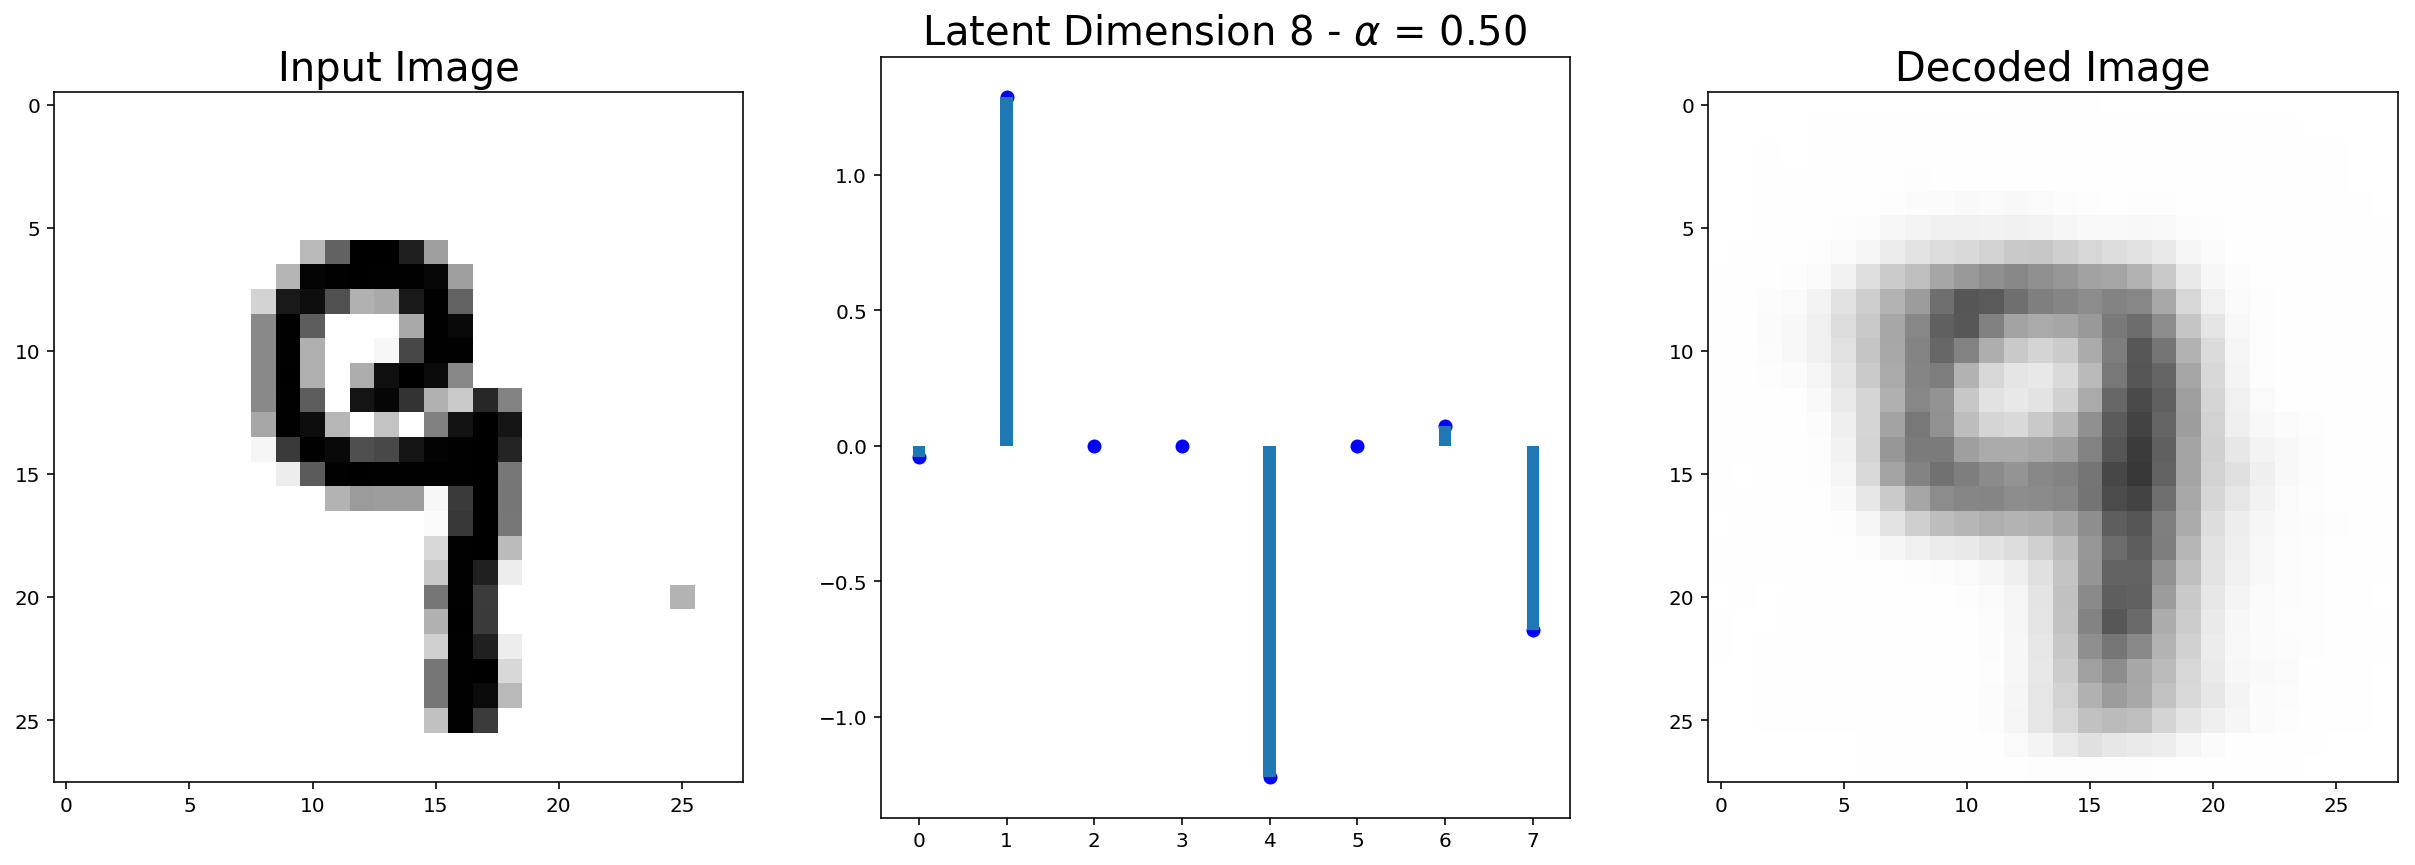

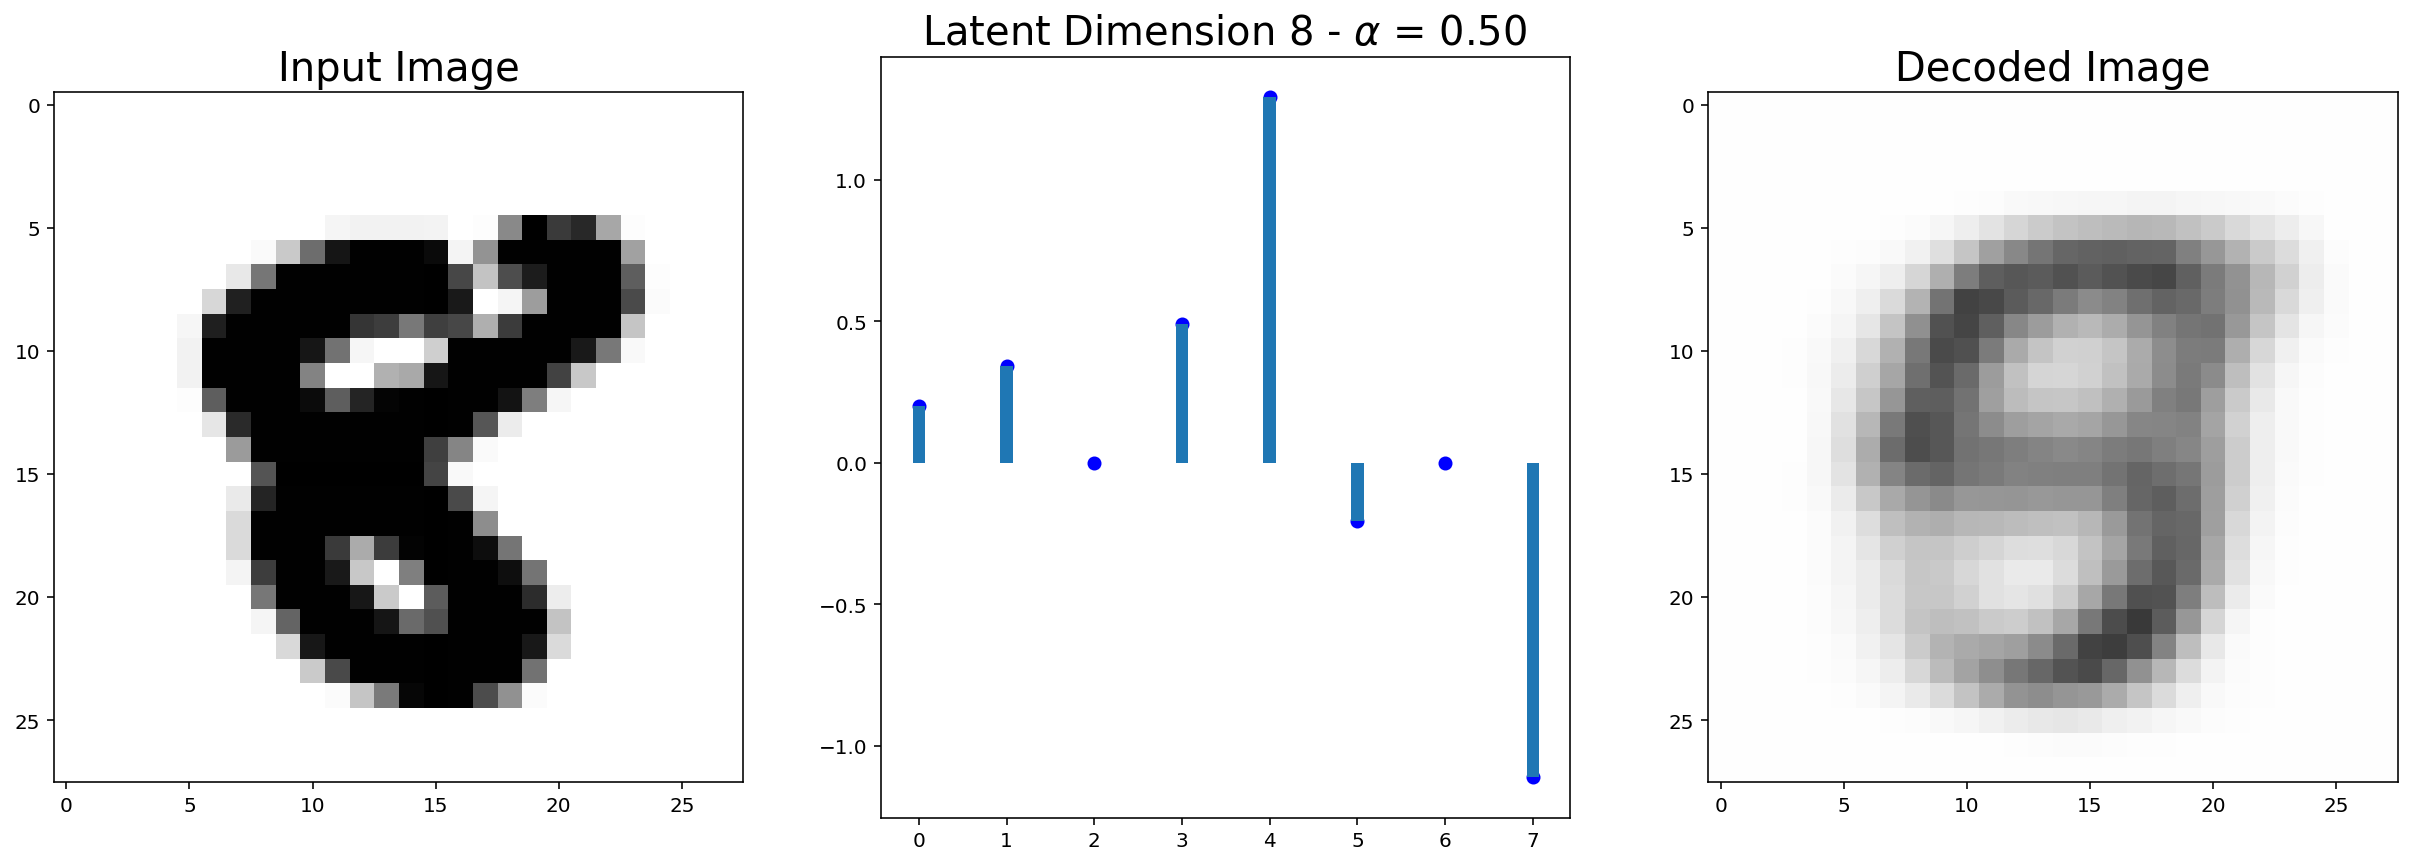

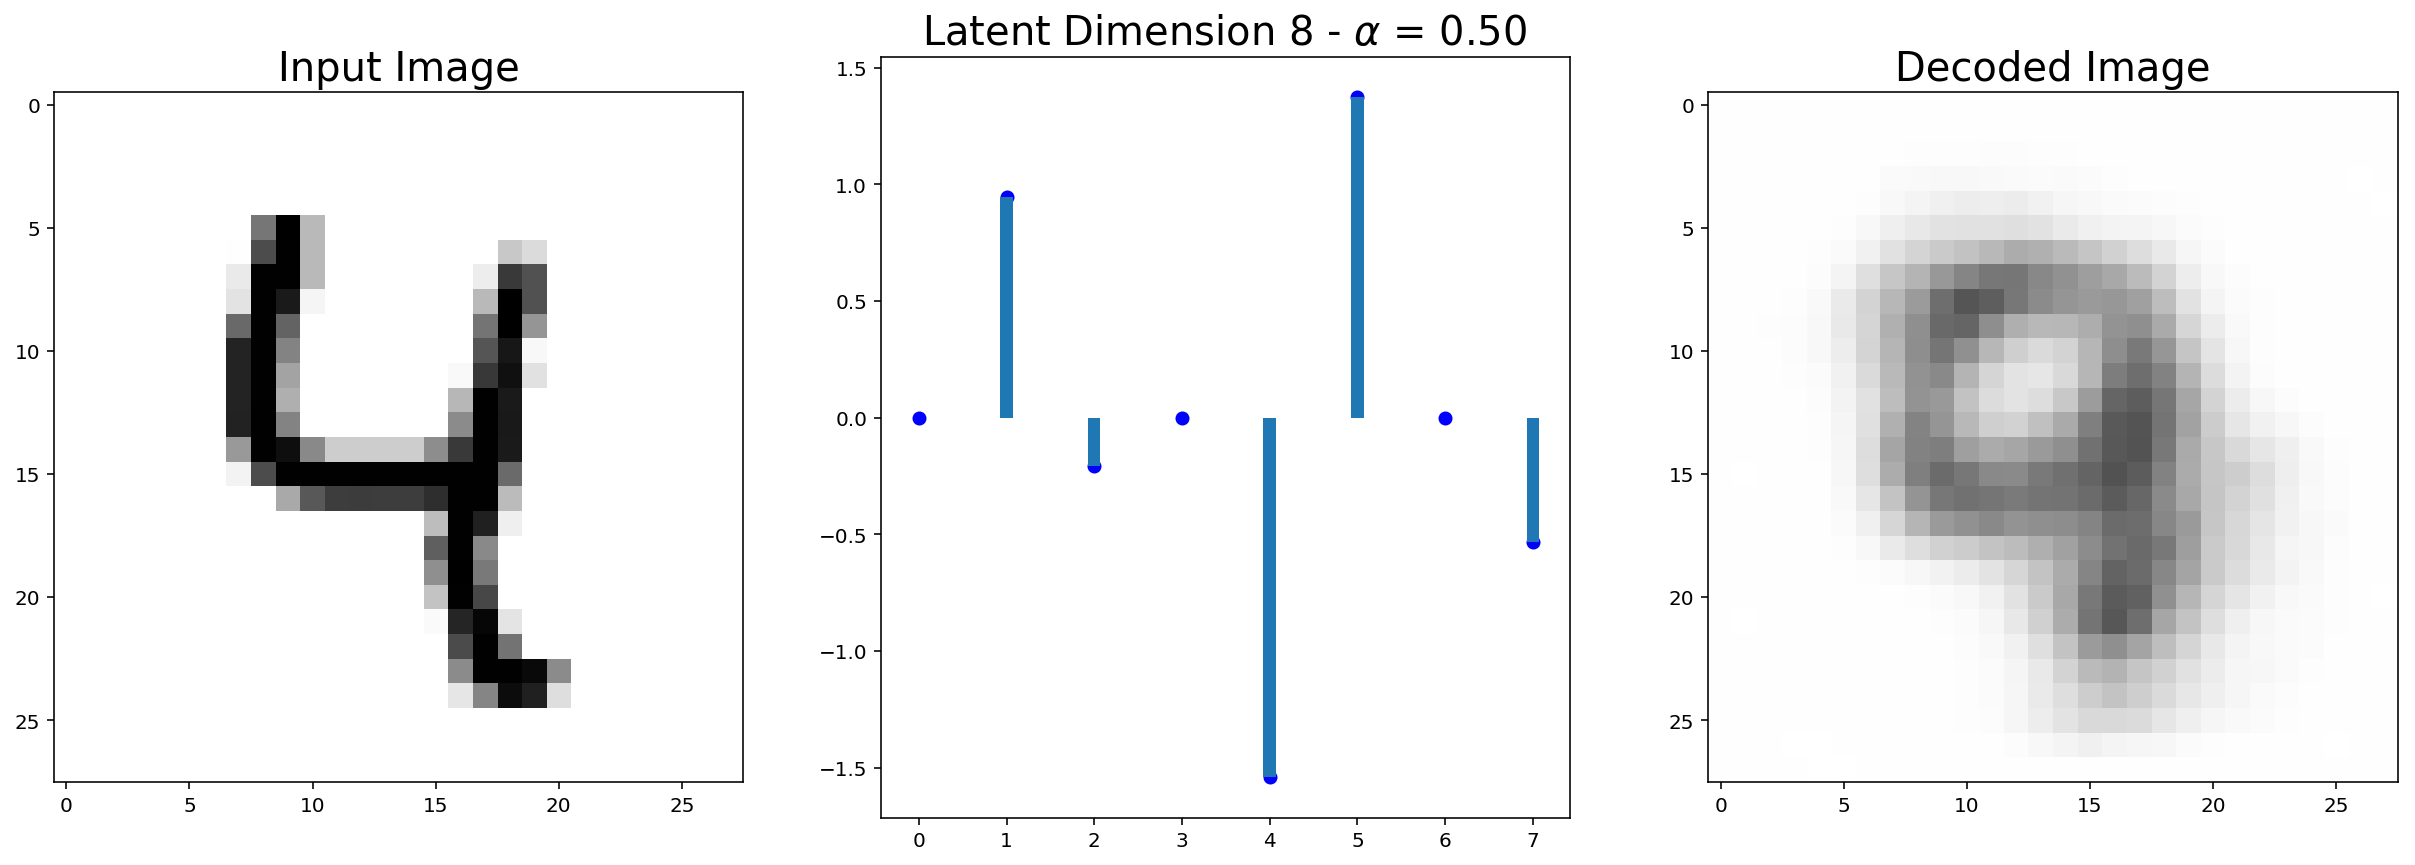

In [23]:
plot_encoding(mnist_images[15], vsc_norm, latent_size, alpha)
plot_encoding(mnist_images[20], vsc_norm, latent_size, alpha)
plot_encoding(mnist_images[25], vsc_norm, latent_size, alpha)

## Standard normalization

In [25]:
normalize = True

from src.models.vsc import VariationalSparseCoding
vsc_std = VariationalSparseCoding(dataset, width, height, channels, hidden_size,
                              latent_size, learning_rate, alpha, device, 
                              log_interval, normalize)

In [26]:
%%time
vsc_std.run_training(train_loader, test_loader, epochs, report_interval, 
                 sample_size, reload_model)

Calculating norm mean of training set
count    4.704000e+07
mean     1.306605e-01
std      3.081078e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
dtype: float64
Done!

Training VSC model...
Train Epoch: 1 [0/60000 (0%)]	Loss: 553.578857
====> Epoch: 1 Average loss: -15041.4489
====> Test set loss: -16495.7942 - VLB-VSC : -527022.1777
Train Epoch: 2 [0/60000 (0%)]	Loss: -16128.634766
====> Epoch: 2 Average loss: -16214.3586
====> Test set loss: -15672.5386 - VLB-VSC : -500720.0835
Train Epoch: 3 [0/60000 (0%)]	Loss: -16325.541992
====> Epoch: 3 Average loss: -15184.6477
====> Test set loss: -14934.6920 - VLB-VSC : -477146.7099
Train Epoch: 4 [0/60000 (0%)]	Loss: -14545.423828
====> Epoch: 4 Average loss: -13894.3335
====> Test set loss: -13709.2415 - VLB-VSC : -437994.9347
Train Epoch: 5 [0/60000 (0%)]	Loss: -12943.801758
====> Epoch: 5 Average loss: -13304.4188
====> Test set loss: -13157.9562 - VLB-VSC : -420381.9859


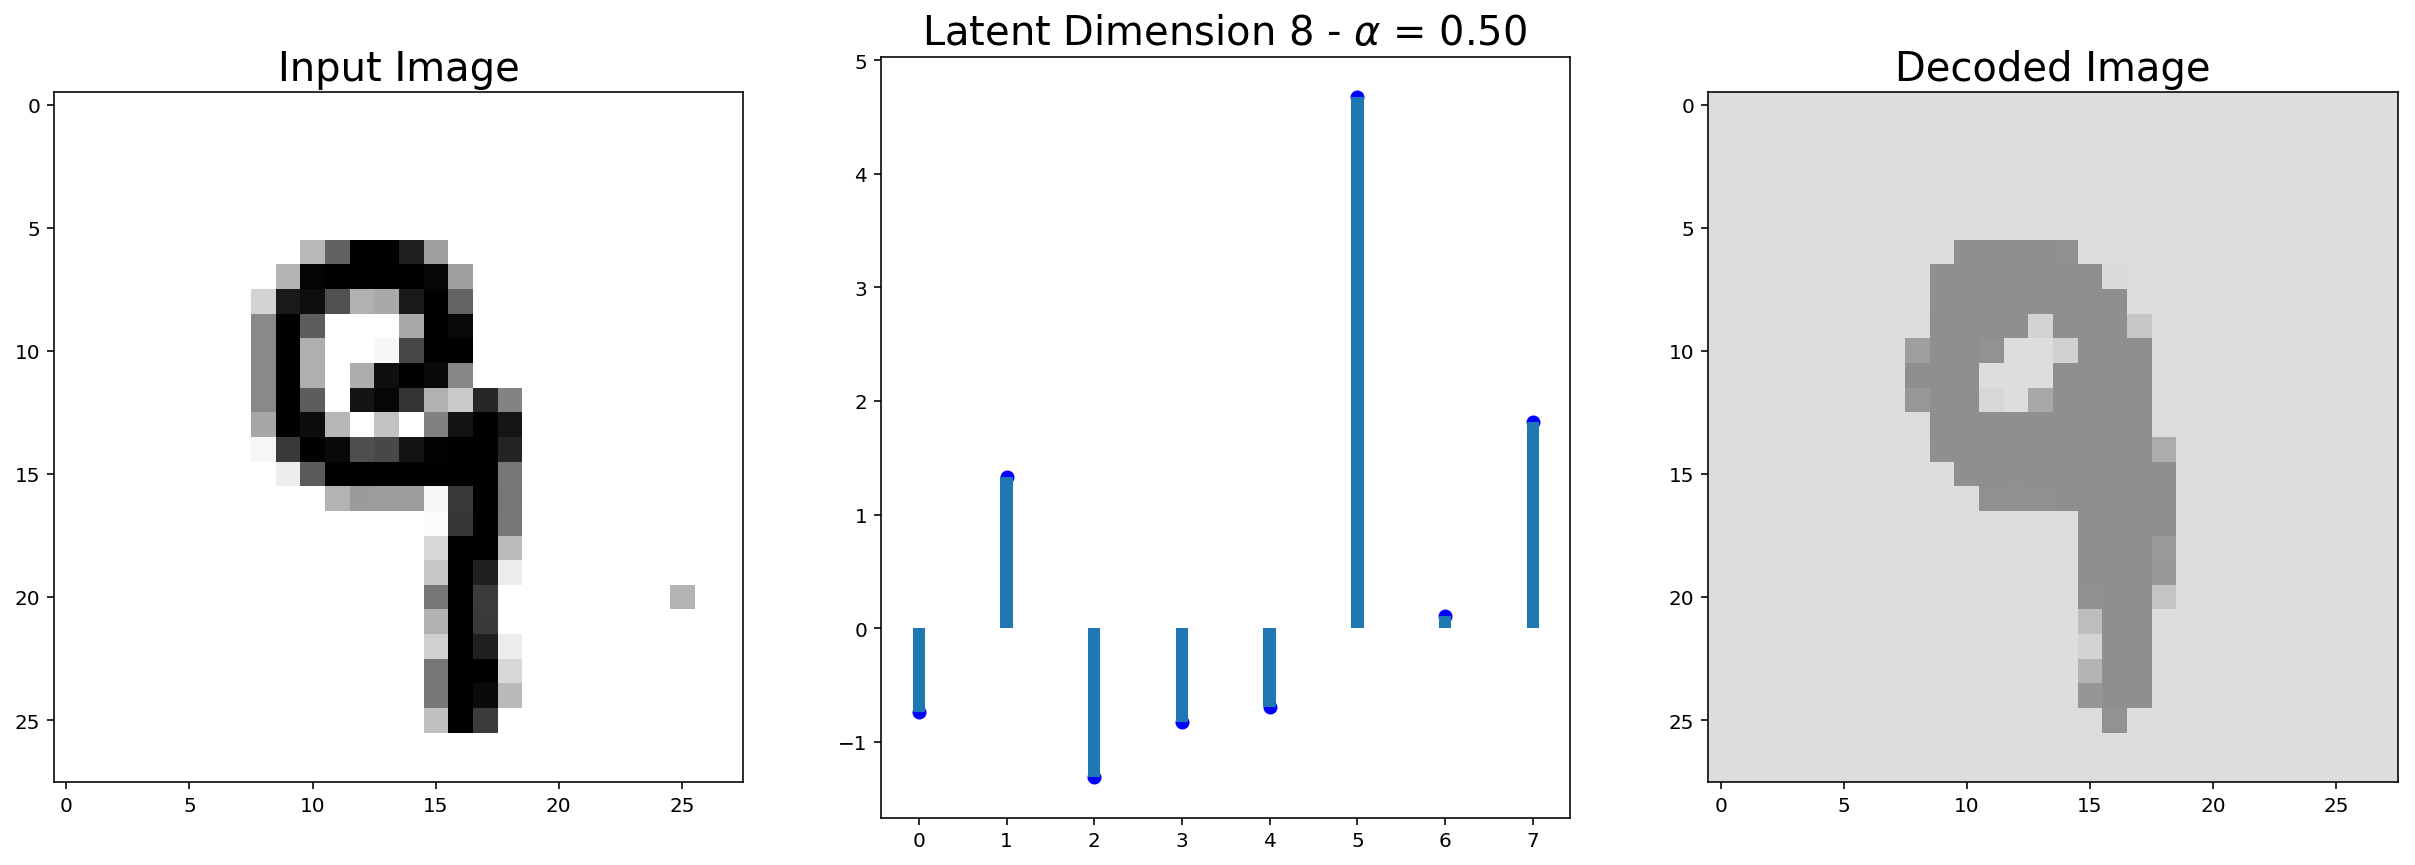

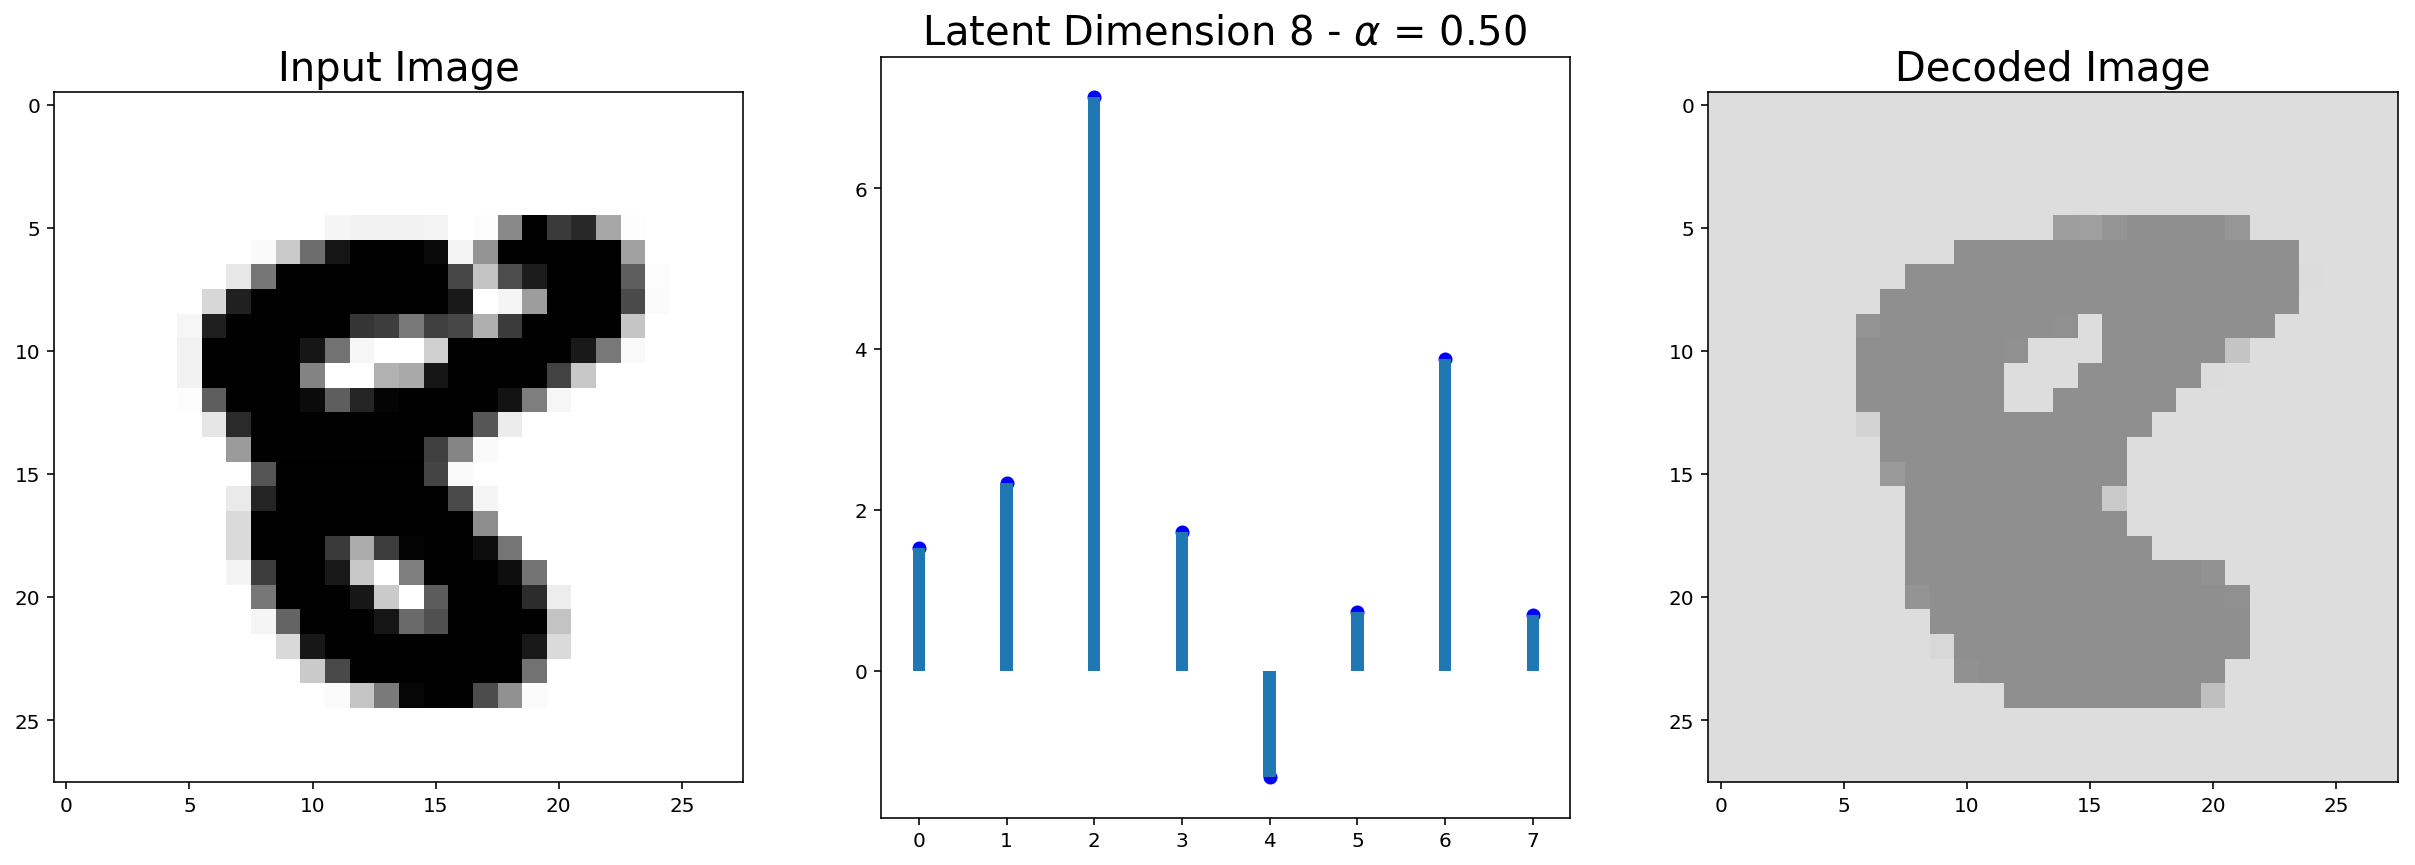

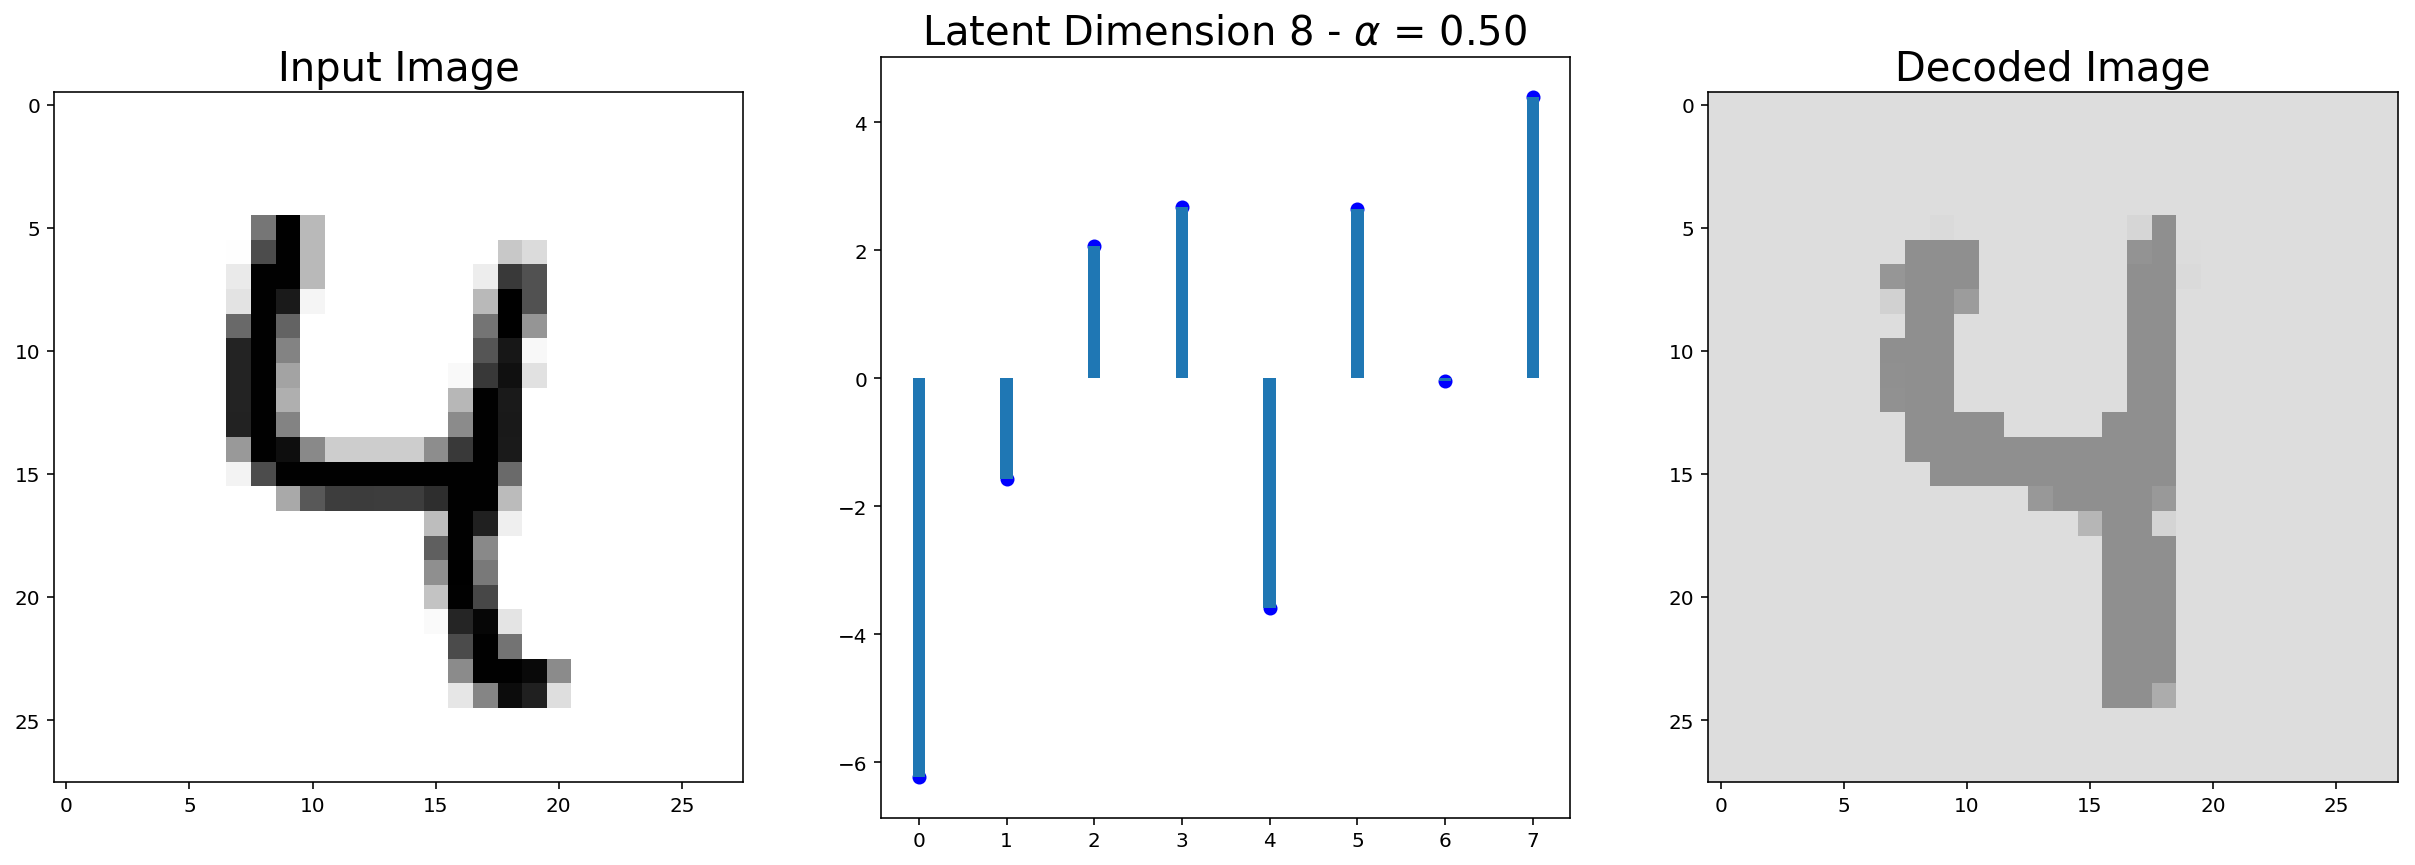

In [27]:
plot_encoding(mnist_images[15], vsc_std, latent_size, alpha)
plot_encoding(mnist_images[20], vsc_std, latent_size, alpha)
plot_encoding(mnist_images[25], vsc_std, latent_size, alpha)

## CelebA

In [34]:
dataset = 'celeba'
normalize = True

In [35]:
from src.utils import get_datasets
train_loader, test_loader, (width, height, channels) = get_datasets(
    dataset, batch_size, device, root='data')

Loading celeba dataset...
Done!



In [36]:
from src.models.vsc import VariationalSparseCoding
vsc_celeba = VariationalSparseCoding(dataset, width, height, channels, hidden_size,
                              latent_size, learning_rate, alpha, device, 
                              log_interval, normalize)

In [37]:
%%time
vsc_celeba.run_training(train_loader, test_loader, epochs, report_interval, 
                 sample_size, reload_model)

Calculating norm mean of training set
count    3.072000e+08
mean     4.355459e-01
std      2.843015e-01
min      0.000000e+00
25%      1.843137e-01
50%      4.117647e-01
75%      6.627451e-01
max      1.000000e+00
dtype: float64
Done!

Training VSC model...
Train Epoch: 1 [0/100000 (0%)]	Loss: 2154.860352
Train Epoch: 1 [64000/100000 (64%)]	Loss: -62380.218750
====> Epoch: 1 Average loss: -58921.6941


Process Process-82:


KeyboardInterrupt: 

Traceback (most recent call last):
  File "/home/raduviri/anaconda3/envs/chana/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/raduviri/anaconda3/envs/chana/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 106, in <listcomp>
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/home/raduviri/Documents/Variational-Sparse-Coding/src/datasets.py", line 32, in __getitem__
    image, target = io.imread(img_name), 0
  File "/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/skimage/io/_io.py", line 62, in imread
    img = call_plugin('imread', fname, plugin=plugi

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [61]:
log_string = '''
Train Epoch: 1 [0/100000 (0%)]	Loss: 5689.484375
====> Epoch: 1 Average loss: 1835.4737
====> Test set loss: 1755.2298 - VLB-VSC : 56167.3540
Train Epoch: 2 [0/100000 (0%)]	Loss: 1787.054810
====> Epoch: 2 Average loss: 1740.8248
====> Test set loss: 1733.7883 - VLB-VSC : 55481.2266
Train Epoch: 3 [0/100000 (0%)]	Loss: 1694.301025
====> Epoch: 3 Average loss: 1724.1958
====> Test set loss: 1718.8977 - VLB-VSC : 55004.7252
Train Epoch: 4 [0/100000 (0%)]	Loss: 1674.164307
====> Epoch: 4 Average loss: 1713.9960
====> Test set loss: 1715.4856 - VLB-VSC : 54895.5386
Train Epoch: 5 [0/100000 (0%)]	Loss: 1731.886963
====> Epoch: 5 Average loss: 1711.0852
====> Test set loss: 1710.7137 - VLB-VSC : 54742.8381
Train Epoch: 6 [0/100000 (0%)]	Loss: 1731.444214
====> Epoch: 6 Average loss: 1709.7847
====> Test set loss: 1709.8639 - VLB-VSC : 54715.6453
Train Epoch: 7 [0/100000 (0%)]	Loss: 1623.995850
====> Epoch: 7 Average loss: 1709.0060
====> Test set loss: 1708.7016 - VLB-VSC : 54678.4519
Train Epoch: 8 [0/100000 (0%)]	Loss: 1752.880127
====> Epoch: 8 Average loss: 1707.9421
====> Test set loss: 1711.4494 - VLB-VSC : 54766.3801
Train Epoch: 9 [0/100000 (0%)]	Loss: 1715.878906
====> Epoch: 9 Average loss: 1706.3723
====> Test set loss: 1706.8871 - VLB-VSC : 54620.3884
Train Epoch: 10 [0/100000 (0%)]	Loss: 1677.053711
====> Epoch: 10 Average loss: 1705.6215
====> Test set loss: 1704.9940 - VLB-VSC : 54559.8092
Train Epoch: 11 [0/100000 (0%)]	Loss: 1806.459473
====> Epoch: 11 Average loss: 1705.0960
====> Test set loss: 1705.0044 - VLB-VSC : 54560.1398
Train Epoch: 12 [0/100000 (0%)]	Loss: 1600.668091
====> Epoch: 12 Average loss: 1704.6227
====> Test set loss: 1705.1649 - VLB-VSC : 54565.2772
Train Epoch: 13 [0/100000 (0%)]	Loss: 1745.309937
====> Epoch: 13 Average loss: 1704.2663
====> Test set loss: 1703.4429 - VLB-VSC : 54510.1713
Train Epoch: 14 [0/100000 (0%)]	Loss: 1672.707520
====> Epoch: 14 Average loss: 1703.9413
====> Test set loss: 1705.3493 - VLB-VSC : 54571.1785
Train Epoch: 15 [0/100000 (0%)]	Loss: 1739.609375
====> Epoch: 15 Average loss: 1703.5685
====> Test set loss: 1704.6411 - VLB-VSC : 54548.5140
Train Epoch: 16 [0/100000 (0%)]	Loss: 1746.385986
====> Epoch: 16 Average loss: 1703.4834
====> Test set loss: 1704.0504 - VLB-VSC : 54529.6127
Train Epoch: 17 [0/100000 (0%)]	Loss: 1755.789551
====> Epoch: 17 Average loss: 1703.3235
====> Test set loss: 1703.4355 - VLB-VSC : 54509.9368
Train Epoch: 18 [0/100000 (0%)]	Loss: 1638.720459
====> Epoch: 18 Average loss: 1702.7108
====> Test set loss: 1703.4213 - VLB-VSC : 54509.4831
Train Epoch: 19 [0/100000 (0%)]	Loss: 1688.834961
====> Epoch: 19 Average loss: 1702.5828
====> Test set loss: 1704.1572 - VLB-VSC : 54533.0300
Train Epoch: 20 [0/100000 (0%)]	Loss: 1786.711060
====> Epoch: 20 Average loss: 1701.5515
====> Test set loss: 1702.3345 - VLB-VSC : 54474.7054
Train Epoch: 21 [0/100000 (0%)]	Loss: 1707.933472
====> Epoch: 21 Average loss: 1700.3152
====> Test set loss: 1699.5241 - VLB-VSC : 54384.7714
Train Epoch: 22 [0/100000 (0%)]	Loss: 1709.782471
====> Epoch: 22 Average loss: 1699.0363
====> Test set loss: 1700.5832 - VLB-VSC : 54418.6624
Train Epoch: 23 [0/100000 (0%)]	Loss: 1707.251831
====> Epoch: 23 Average loss: 1698.6066
====> Test set loss: 1699.1228 - VLB-VSC : 54371.9281
Train Epoch: 24 [0/100000 (0%)]	Loss: 1718.483521
====> Epoch: 24 Average loss: 1698.2754
====> Test set loss: 1698.4412 - VLB-VSC : 54350.1194
Train Epoch: 25 [0/100000 (0%)]	Loss: 1707.810425
====> Epoch: 25 Average loss: 1698.0664
====> Test set loss: 1698.2173 - VLB-VSC : 54342.9543
Train Epoch: 26 [0/100000 (0%)]	Loss: 1699.577148
====> Epoch: 26 Average loss: 1697.7908
====> Test set loss: 1698.5813 - VLB-VSC : 54354.6017
Train Epoch: 27 [0/100000 (0%)]	Loss: 1730.689331
====> Epoch: 27 Average loss: 1697.6893
====> Test set loss: 1698.7935 - VLB-VSC : 54361.3914
Train Epoch: 28 [0/100000 (0%)]	Loss: 1673.231567
====> Epoch: 28 Average loss: 1697.4509
====> Test set loss: 1697.8477 - VLB-VSC : 54331.1260
Train Epoch: 29 [0/100000 (0%)]	Loss: 1707.536133
====> Epoch: 29 Average loss: 1697.3227
====> Test set loss: 1697.7019 - VLB-VSC : 54326.4599
Train Epoch: 30 [0/100000 (0%)]	Loss: 1672.713623
====> Epoch: 30 Average loss: 1697.0275
====> Test set loss: 1696.8576 - VLB-VSC : 54299.4430
''' + \
'''
Train Epoch: 1 [0/100000 (0%)]	Loss: 1686.513916
====> Epoch: 1 Average loss: 1696.9717
====> Test set loss: 1697.5390 - VLB-VSC : 54321.2487
Train Epoch: 2 [0/100000 (0%)]	Loss: 1750.252930
====> Epoch: 2 Average loss: 1696.7125
====> Test set loss: 1697.3584 - VLB-VSC : 54315.4676
Train Epoch: 3 [0/100000 (0%)]	Loss: 1678.456665
====> Epoch: 3 Average loss: 1696.6412
====> Test set loss: 1698.0579 - VLB-VSC : 54337.8520
Train Epoch: 4 [0/100000 (0%)]	Loss: 1720.273804
====> Epoch: 4 Average loss: 1696.4913
====> Test set loss: 1697.4860 - VLB-VSC : 54319.5524
Train Epoch: 5 [0/100000 (0%)]	Loss: 1734.922119
====> Epoch: 5 Average loss: 1696.2824
====> Test set loss: 1696.6263 - VLB-VSC : 54292.0429
Train Epoch: 6 [0/100000 (0%)]	Loss: 1747.381104
====> Epoch: 6 Average loss: 1696.3037
====> Test set loss: 1696.3359 - VLB-VSC : 54282.7494
Train Epoch: 7 [0/100000 (0%)]	Loss: 1722.430054
====> Epoch: 7 Average loss: 1695.9686
====> Test set loss: 1696.4743 - VLB-VSC : 54287.1784
Train Epoch: 8 [0/100000 (0%)]	Loss: 1667.647339
====> Epoch: 8 Average loss: 1696.1113
====> Test set loss: 1696.3667 - VLB-VSC : 54283.7341
Train Epoch: 9 [0/100000 (0%)]	Loss: 1648.386841
====> Epoch: 9 Average loss: 1695.9127
====> Test set loss: 1696.3699 - VLB-VSC : 54283.8377
Train Epoch: 10 [0/100000 (0%)]	Loss: 1665.324829
====> Epoch: 10 Average loss: 1695.8104
====> Test set loss: 1696.4843 - VLB-VSC : 54287.4983
Train Epoch: 11 [0/100000 (0%)]	Loss: 1658.455078
====> Epoch: 11 Average loss: 1695.6662
====> Test set loss: 1695.7683 - VLB-VSC : 54264.5850
Train Epoch: 12 [0/100000 (0%)]	Loss: 1636.336182
====> Epoch: 12 Average loss: 1695.0029
====> Test set loss: 1697.5734 - VLB-VSC : 54322.3487
Train Epoch: 13 [0/100000 (0%)]	Loss: 1722.763306
====> Epoch: 13 Average loss: 1694.5446
====> Test set loss: 1695.4106 - VLB-VSC : 54253.1390
Train Epoch: 14 [0/100000 (0%)]	Loss: 1662.755493
====> Epoch: 14 Average loss: 1694.3766
====> Test set loss: 1695.4233 - VLB-VSC : 54253.5452
Train Epoch: 15 [0/100000 (0%)]	Loss: 1640.734009
====> Epoch: 15 Average loss: 1694.0172
====> Test set loss: 1695.3854 - VLB-VSC : 54252.3338
Train Epoch: 16 [0/100000 (0%)]	Loss: 1669.123169
====> Epoch: 16 Average loss: 1694.0502
====> Test set loss: 1694.8745 - VLB-VSC : 54235.9836
Train Epoch: 17 [0/100000 (0%)]	Loss: 1682.176514
====> Epoch: 17 Average loss: 1693.9918
====> Test set loss: 1693.5639 - VLB-VSC : 54194.0457
Train Epoch: 18 [0/100000 (0%)]	Loss: 1736.283447
====> Epoch: 18 Average loss: 1693.8122
====> Test set loss: 1693.9995 - VLB-VSC : 54207.9828
Train Epoch: 19 [0/100000 (0%)]	Loss: 1740.832153
====> Epoch: 19 Average loss: 1693.8085
====> Test set loss: 1693.5556 - VLB-VSC : 54193.7797
Train Epoch: 20 [0/100000 (0%)]	Loss: 1638.573120
====> Epoch: 20 Average loss: 1693.5803
====> Test set loss: 1694.0100 - VLB-VSC : 54208.3203
Train Epoch: 21 [0/100000 (0%)]	Loss: 1740.368530
====> Epoch: 21 Average loss: 1693.5513
====> Test set loss: 1694.3264 - VLB-VSC : 54218.4450
Train Epoch: 22 [0/100000 (0%)]	Loss: 1637.693970
====> Epoch: 22 Average loss: 1693.4194
====> Test set loss: 1695.7271 - VLB-VSC : 54263.2668
Train Epoch: 23 [0/100000 (0%)]	Loss: 1734.523804
====> Epoch: 23 Average loss: 1693.3992
====> Test set loss: 1694.6281 - VLB-VSC : 54228.0995
Train Epoch: 24 [0/100000 (0%)]	Loss: 1746.583130
====> Epoch: 24 Average loss: 1693.6535
====> Test set loss: 1694.5542 - VLB-VSC : 54225.7350
Train Epoch: 25 [0/100000 (0%)]	Loss: 1682.028442
====> Epoch: 25 Average loss: 1693.2187
====> Test set loss: 1694.9667 - VLB-VSC : 54238.9348
Train Epoch: 26 [0/100000 (0%)]	Loss: 1690.396851
====> Epoch: 26 Average loss: 1693.1783
====> Test set loss: 1694.1980 - VLB-VSC : 54214.3363
Train Epoch: 27 [0/100000 (0%)]	Loss: 1689.114136
====> Epoch: 27 Average loss: 1693.1851
====> Test set loss: 1695.3596 - VLB-VSC : 54251.5081
Train Epoch: 28 [0/100000 (0%)]	Loss: 1766.255493
====> Epoch: 28 Average loss: 1693.0854
====> Test set loss: 1693.3807 - VLB-VSC : 54188.1817
Train Epoch: 29 [0/100000 (0%)]	Loss: 1731.016113
====> Epoch: 29 Average loss: 1693.1150
====> Test set loss: 1694.4308 - VLB-VSC : 54221.7860
Train Epoch: 30 [0/100000 (0%)]	Loss: 1695.977051
====> Epoch: 30 Average loss: 1693.1029
====> Test set loss: 1694.2418 - VLB-VSC : 54215.7386
''' + \
'''
Train Epoch: 1 [0/100000 (0%)]	Loss: 1681.621338
====> Epoch: 1 Average loss: 1693.0528
====> Test set loss: 1693.0196 - VLB-VSC : 54176.6277
Train Epoch: 2 [0/100000 (0%)]	Loss: 1729.291748
====> Epoch: 2 Average loss: 1693.7206
====> Test set loss: 1694.1158 - VLB-VSC : 54211.7058
Train Epoch: 3 [0/100000 (0%)]	Loss: 1743.691040
====> Epoch: 3 Average loss: 1693.1655
====> Test set loss: 1693.8798 - VLB-VSC : 54204.1541
Train Epoch: 4 [0/100000 (0%)]	Loss: 1722.714966
====> Epoch: 4 Average loss: 1693.0964
====> Test set loss: 1694.0269 - VLB-VSC : 54208.8605
Train Epoch: 5 [0/100000 (0%)]	Loss: 1666.730469
====> Epoch: 5 Average loss: 1693.2528
====> Test set loss: 1694.0203 - VLB-VSC : 54208.6504
Train Epoch: 6 [0/100000 (0%)]	Loss: 1622.456177
====> Epoch: 6 Average loss: 1692.9522
====> Test set loss: 1694.4379 - VLB-VSC : 54222.0123
Train Epoch: 7 [0/100000 (0%)]	Loss: 1700.427124
====> Epoch: 7 Average loss: 1693.2901
====> Test set loss: 1693.6987 - VLB-VSC : 54198.3576
Train Epoch: 8 [0/100000 (0%)]	Loss: 1702.889038
====> Epoch: 8 Average loss: 1692.9136
====> Test set loss: 1693.9063 - VLB-VSC : 54205.0010
Train Epoch: 9 [0/100000 (0%)]	Loss: 1689.848999
====> Epoch: 9 Average loss: 1692.9834
====> Test set loss: 1694.2192 - VLB-VSC : 54215.0139
Train Epoch: 10 [0/100000 (0%)]	Loss: 1631.144043
====> Epoch: 10 Average loss: 1692.7528
====> Test set loss: 1693.9308 - VLB-VSC : 54205.7852
Train Epoch: 11 [0/100000 (0%)]	Loss: 1669.336548
====> Epoch: 11 Average loss: 1692.8425
====> Test set loss: 1693.1306 - VLB-VSC : 54180.1800
Train Epoch: 12 [0/100000 (0%)]	Loss: 1694.871704
====> Epoch: 12 Average loss: 1692.7246
====> Test set loss: 1693.1477 - VLB-VSC : 54180.7250
Train Epoch: 13 [0/100000 (0%)]	Loss: 1624.531616
====> Epoch: 13 Average loss: 1692.6288
====> Test set loss: 1693.0323 - VLB-VSC : 54177.0337
Train Epoch: 14 [0/100000 (0%)]	Loss: 1764.170288
====> Epoch: 14 Average loss: 1692.7391
====> Test set loss: 1694.6664 - VLB-VSC : 54229.3248
Train Epoch: 15 [0/100000 (0%)]	Loss: 1718.959961
====> Epoch: 15 Average loss: 1692.8020
====> Test set loss: 1695.5318 - VLB-VSC : 54257.0186
Train Epoch: 16 [0/100000 (0%)]	Loss: 1738.366333
====> Epoch: 16 Average loss: 1692.8131
====> Test set loss: 1693.9012 - VLB-VSC : 54204.8383
Train Epoch: 17 [0/100000 (0%)]	Loss: 1780.665405
====> Epoch: 17 Average loss: 1692.6929
====> Test set loss: 1694.1893 - VLB-VSC : 54214.0564
Train Epoch: 18 [0/100000 (0%)]	Loss: 1700.573242
====> Epoch: 18 Average loss: 1692.5998
====> Test set loss: 1692.9944 - VLB-VSC : 54175.8193
Train Epoch: 19 [0/100000 (0%)]	Loss: 1666.683228
====> Epoch: 19 Average loss: 1692.6059
====> Test set loss: 1693.6014 - VLB-VSC : 54195.2443
Train Epoch: 20 [0/100000 (0%)]	Loss: 1681.634521
====> Epoch: 20 Average loss: 1692.6030
====> Test set loss: 1693.5073 - VLB-VSC : 54192.2341
Train Epoch: 21 [0/100000 (0%)]	Loss: 1719.001709
====> Epoch: 21 Average loss: 1692.5986
====> Test set loss: 1693.0948 - VLB-VSC : 54179.0337
Train Epoch: 22 [0/100000 (0%)]	Loss: 1690.358765
====> Epoch: 22 Average loss: 1692.5565
====> Test set loss: 1693.3941 - VLB-VSC : 54188.6111
Train Epoch: 23 [0/100000 (0%)]	Loss: 1709.769409
====> Epoch: 23 Average loss: 1692.8717
====> Test set loss: 1692.8447 - VLB-VSC : 54171.0302
Train Epoch: 24 [0/100000 (0%)]	Loss: 1644.027344
====> Epoch: 24 Average loss: 1692.9713
====> Test set loss: 1694.6265 - VLB-VSC : 54228.0465
Train Epoch: 25 [0/100000 (0%)]	Loss: 1724.537720
====> Epoch: 25 Average loss: 1692.7335
====> Test set loss: 1693.8885 - VLB-VSC : 54204.4320
Train Epoch: 26 [0/100000 (0%)]	Loss: 1711.581177
====> Epoch: 26 Average loss: 1692.7777
====> Test set loss: 1693.5250 - VLB-VSC : 54192.8009
Train Epoch: 27 [0/100000 (0%)]	Loss: 1670.813477
====> Epoch: 27 Average loss: 1692.7096
====> Test set loss: 1695.2470 - VLB-VSC : 54247.9052
Train Epoch: 28 [0/100000 (0%)]	Loss: 1781.289185
====> Epoch: 28 Average loss: 1692.7475
====> Test set loss: 1693.8427 - VLB-VSC : 54202.9668
Train Epoch: 29 [0/100000 (0%)]	Loss: 1688.119385
====> Epoch: 29 Average loss: 1692.9588
====> Test set loss: 1695.0565 - VLB-VSC : 54241.8073
Train Epoch: 30 [0/100000 (0%)]	Loss: 1667.419189
====> Epoch: 30 Average loss: 1692.8087
====> Test set loss: 1693.6880 - VLB-VSC : 54198.0146
'''

In [62]:
train = [float(line.split()[-1]) \
         for line in log_string.strip().split('\n') \
         if 'Average loss' in line]

In [63]:
test = [float(line.split()[4]) \
         for line in log_string.strip().split('\n') \
         if 'Test set' in line]

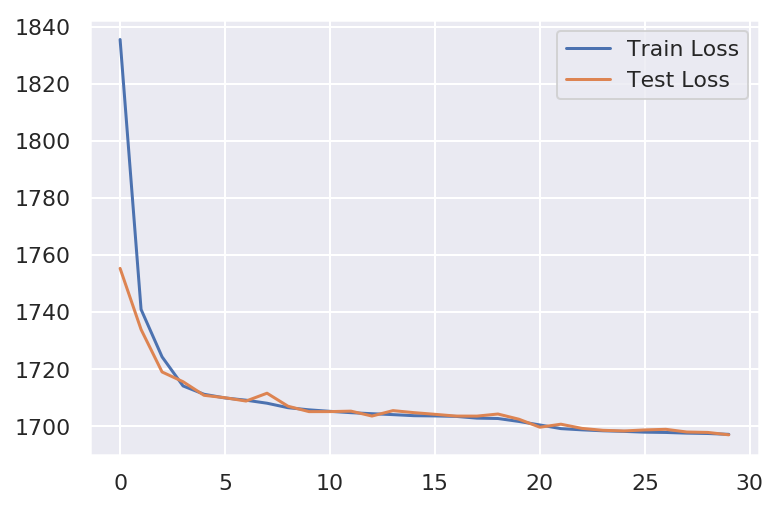

In [15]:
log = pd.DataFrame()
log['Train Loss'] = train
log['Test Loss'] = test
log.plot()

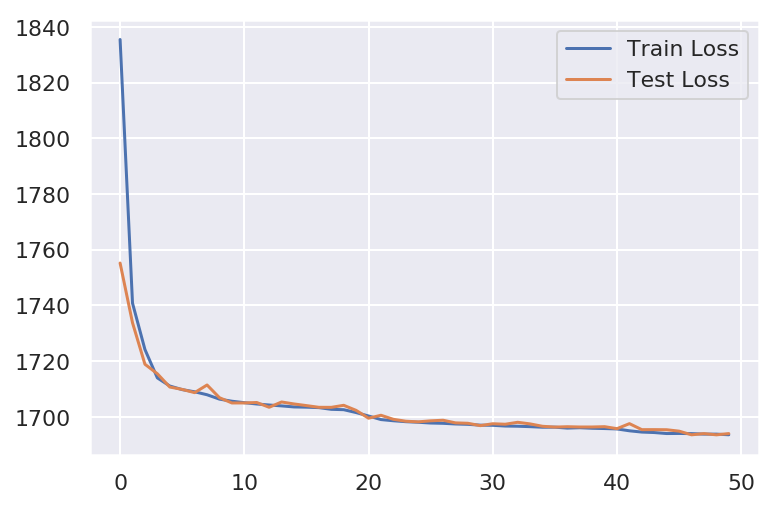

In [21]:
log = pd.DataFrame()
log['Train Loss'] = train
log['Test Loss'] = test
log.plot()

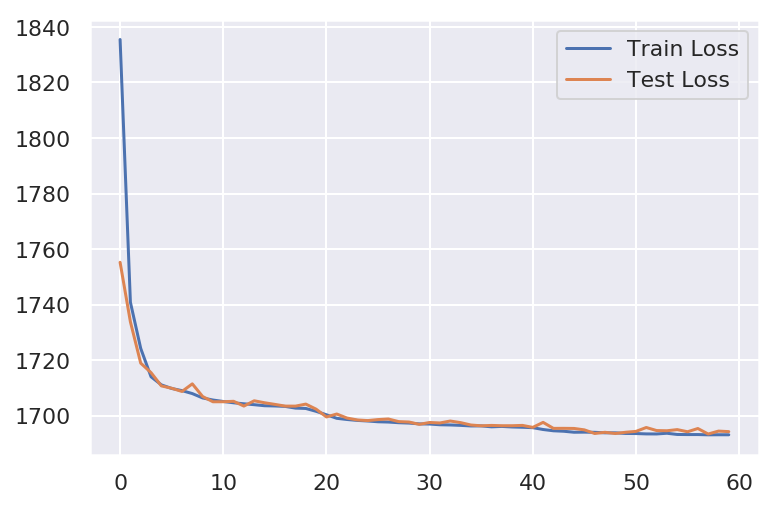

In [35]:
log = pd.DataFrame()
log['Train Loss'] = train
log['Test Loss'] = test
log.plot()

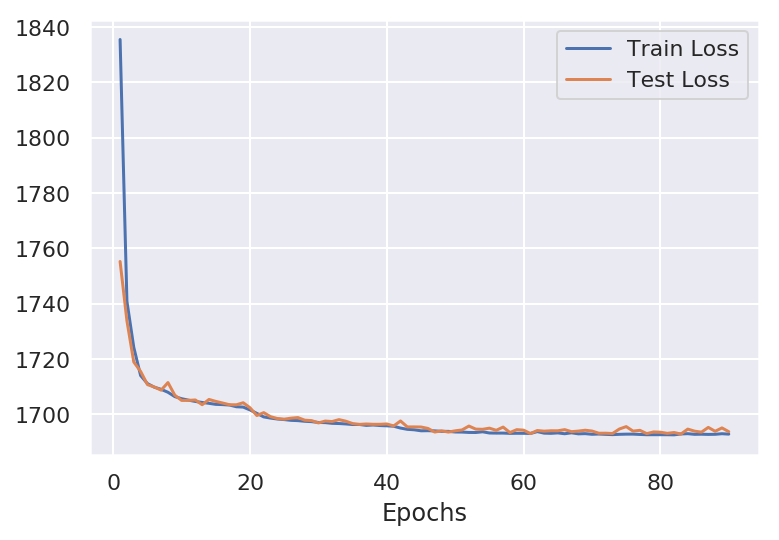

In [64]:
log = pd.DataFrame()
log['Train Loss'] = train
log['Test Loss'] = test
log.index = np.arange(1, len(log) + 1)
ax = log.plot()
ax.set(xlabel="Epochs");